# Cell type deconvolution using `STitch3D`

In [1]:
import sys
sys.path.append(r'/import/home/share/zw/pql/STitch3D/')
import STitch3D

import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
from scipy.io import mmread
import os

import warnings
warnings.filterwarnings("ignore")

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

/home/zwanghc/anaconda3/envs/stitch3d/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/import/home/share/zw/pql/STitch3D/STitch3D/__init__.py


In [2]:
DATA_PATH = "/import/home/share/zw/data/mouse_brain"
SAVE_PATH = "/import/home/share/zw/pql/data/mouse_brain"

os.makedirs(os.path.join(SAVE_PATH, "visium_1"), exist_ok=True)
os.makedirs(os.path.join(SAVE_PATH, "visium_2"), exist_ok=True)
os.makedirs(os.path.join(SAVE_PATH, "ST_3D"), exist_ok=True)

In [3]:
# scRNA-seq reference data

adata_ref = sc.read_h5ad(os.path.join(DATA_PATH, "reference/all_cells_20200625.h5ad"))
adata_ref.var.index = adata_ref.var["SYMBOL"].astype(str)
adata_ref.var_names_make_unique() # make gene names unique

labels = pd.read_csv(os.path.join(DATA_PATH, "reference/snRNA_annotation_astro_subtypes_refined59_20200823.csv"), index_col=0)
labels = labels.reindex(index=adata_ref.obs_names)

adata_ref.obs[labels.columns] = labels
adata_ref = adata_ref[~adata_ref.obs['annotation_1'].isna(), :]
adata_ref.obs['celltype'] = adata_ref.obs['annotation_1']

Trying to set attribute `.obs` of view, copying.


## 10x Visium Slice 1

In [ ]:
counts = pd.read_csv(os.path.join(DATA_PATH, "visium_1/mouse_brain_visium_1_counts.csv"), index_col=0)
coordinates = pd.read_csv(os.path.join(DATA_PATH, "visium_1/mouse_brain_visium_1_coordinates.csv"), index_col=0)

adata_st = ad.AnnData(X = counts.values)
adata_st.obs.index = counts.index
adata_st.var.index = counts.columns
adata_st.obsm['spatial'] = coordinates.values

adata_st.obs["array_row"] = coordinates.iloc[:, 0]
adata_st.obs["array_col"] = coordinates.iloc[:, 1]
adata_st_list_raw = [adata_st]

In [ ]:
adata_st_list = STitch3D.utils.align_spots(adata_st_list_raw, data_type = "other", coor_key = "spatial", plot = False) # Since the original array_col and array_row are not valid, we set data_type = "other"

In [ ]:
adata_st, adata_basis = STitch3D.utils.preprocess(adata_st_list,
                                                  adata_ref,
                                                  celltype_ref_col = "celltype",
                                                  n_hvg_group = 500,
                                                  save_path = os.path.join(SAVE_PATH, "visium_1"))

In [ ]:
model = STitch3D.model.Model(adata_st, adata_basis)
model.train()
result = model.eval(adata_st_list_raw, save = True, output_path = os.path.join(SAVE_PATH, "visium_1"))

## 10x Visium Slice 2

In [ ]:
counts = pd.read_csv(os.path.join(DATA_PATH, "visium_2/mouse_brain_visium_2_counts.csv"), index_col=0)
coordinates = pd.read_csv(os.path.join(DATA_PATH, "visium_2/mouse_brain_visium_2_coordinates.csv"), index_col=0)

adata_st = ad.AnnData(X = counts.values)
adata_st.obs.index = counts.index
adata_st.var.index = counts.columns
adata_st.obsm['spatial'] = coordinates.values

adata_st.obs["array_row"] = coordinates.iloc[:, 0]
adata_st.obs["array_col"] = coordinates.iloc[:, 1]
adata_st_list_raw = [adata_st]

In [ ]:
adata_st_list = STitch3D.utils.align_spots(adata_st_list_raw, data_type = "other", coor_key = "spatial", plot = False) # Since the original array_col and array_row are not valid, we set data_type = "other"

In [ ]:
adata_st, adata_basis = STitch3D.utils.preprocess(adata_st_list,
                                                  adata_ref,
                                                  celltype_ref_col="celltype",
                                                  n_hvg_group = 500,
                                                  save_path = os.path.join(SAVE_PATH, "visium_2"))

In [ ]:
model = STitch3D.model.Model(adata_st, adata_basis)
model.train()
result = model.eval(adata_st_list_raw, save = True, output_path = os.path.join(SAVE_PATH, "visium_2"))

# Integrate multiple slices profiled by Spatial Transcriptomics

In [4]:
counts = pd.read_csv(os.path.join(DATA_PATH, "ST", "GSE147747_expr_raw_counts_table.tsv"),
                     sep="\t", index_col=0)

meta = pd.read_csv(os.path.join(DATA_PATH, "ST", "GSE147747_meta_table.tsv"),
                   sep="\t", index_col=0)

adata_st_all = ad.AnnData(X = counts.values)
adata_st_all.obs.index = counts.index
adata_st_all.obs = meta.loc[adata_st_all.obs.index]
adata_st_all.var.index = counts.columns

slice_use = ['01A', '02A', '03A', '04B', '05A', '06B', '07A', '08B', '09A', '10B',
 '11A', '12A', '13B', '14A', '15A', '16A', '17A', '18A', '19A', '20B',
 '21A', '22A', '23A', '24A', '25A', '26A', '27A', '28A', '29A', '30A',
 '31A', '32A', '33A', '34A', '35A',]

meta_slice = pd.read_csv(os.path.join(DATA_PATH, "ST", "molecular-atlas-master/data/slicestable.tsv"),
                         index_col=0, sep="\t")
slice_AP = [float(meta_slice.loc[s]['AP']) * 1000 for s in slice_use]
slice_dist_micron = [-(slice_AP[i+1] - slice_AP[i]) for i in range(len(slice_AP)-1)]

adata_st_all = adata_st_all[[s in slice_use for s in adata_st_all.obs.section_index.values]]
sc.pp.filter_cells(adata_st_all, min_genes=1)

adata_st_all.obsm['spatial'] = np.concatenate((adata_st_all.obs['HE_X'].values.reshape(-1, 1),
                                               adata_st_all.obs['HE_Y'].values.reshape(-1, 1)), axis=1)

adata_st_list_raw = []

for slice_id in sorted(set(adata_st_all.obs.section_index.values)):
    adata_st_i = adata_st_all[adata_st_all.obs.section_index.values == slice_id]

    array_col = np.array([np.float(loc.split("_")[1].split("x")[0]) for loc in adata_st_i.obs.index])
    if slice_id == '01A':
        array_col = array_col - 0.3
    array_row = np.array([np.float(loc.split("_")[1].split("x")[1]) for loc in adata_st_i.obs.index])

    adata_st_i.obs['array_col'] = np.round(array_col)
    adata_st_i.obs['array_row'] = np.round(array_row)
    adata_st_i.obsm['loc_use'] = np.concatenate((adata_st_i.obs['array_row'].values.reshape(-1, 1),
                                                 adata_st_i.obs['array_col'].values.reshape(-1, 1)), axis=1)

    adata_st_list_raw.append(adata_st_i.copy())

for i in range(1, 6): # adjust spatial locations
    adata_st_list_raw[i].obsm['loc_use'] = np.concatenate((adata_st_list_raw[i].obsm['loc_use'][:, 0].reshape(-1, 1),
                                                           2*np.mean(adata_st_list_raw[i].obsm['loc_use'][:, 1])-adata_st_list_raw[i].obsm['loc_use'][:, 1].reshape(-1, 1)), axis=1)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

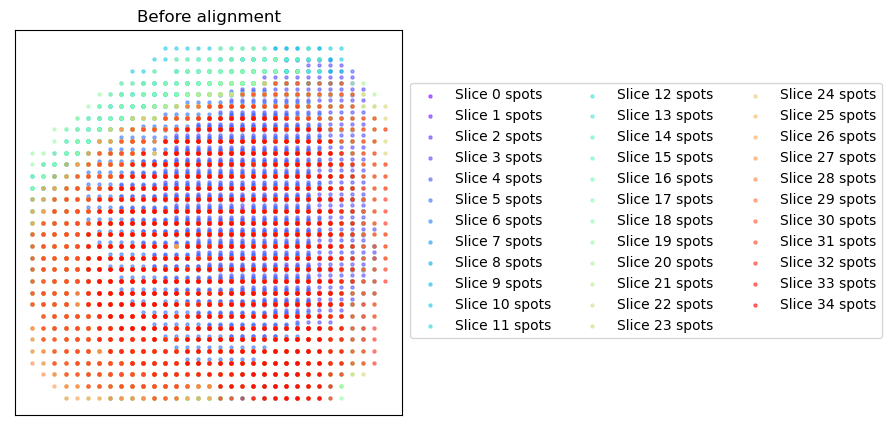

Using the Iterative Closest Point algorithm for alignemnt.
Detecting edges...
Aligning edges...


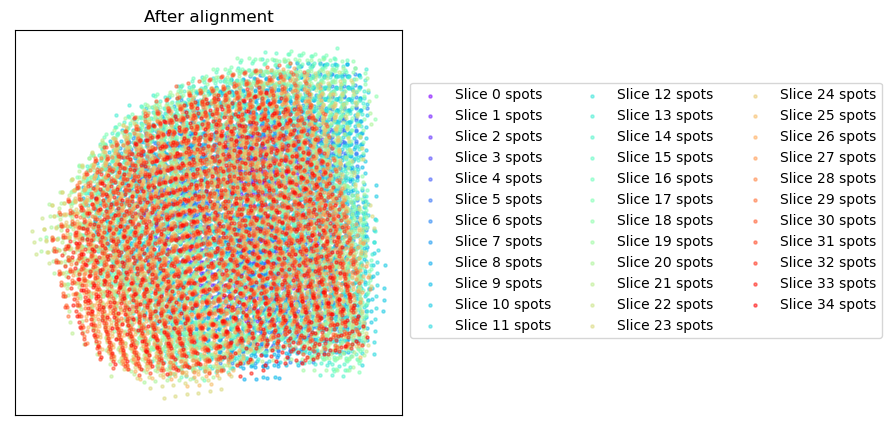

In [5]:
adata_st_list = STitch3D.utils.align_spots(adata_st_list_raw,
                                           data_type = "ST",
                                           coor_key = "loc_use",
                                           plot = True)

In [6]:
adata_st, adata_basis = STitch3D.utils.preprocess(adata_st_list,
                                                  adata_ref,
                                                  sample_col = "sample",
                                                  coor_key = "loc_use",
                                                  slice_dist_micron = slice_dist_micron,
                                                  c2c_dist = 200.,
                                                  n_hvg_group = 500,
                                                  save_path = os.path.join(SAVE_PATH, "ST_3D"))

Finding highly variable genes...


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

6227 highly variable genes selected.
Calculate basis for deconvolution...


Trying to set attribute `.obs` of view, copying.


6 batches are used for computing the basis vector of cell type <Astro_AMY>.
6 batches are used for computing the basis vector of cell type <Astro_AMY_CTX>.
6 batches are used for computing the basis vector of cell type <Astro_CTX>.
6 batches are used for computing the basis vector of cell type <Astro_HPC>.
6 batches are used for computing the basis vector of cell type <Astro_HYPO>.
4 batches are used for computing the basis vector of cell type <Astro_STR>.
5 batches are used for computing the basis vector of cell type <Astro_THAL_hab>.
6 batches are used for computing the basis vector of cell type <Astro_THAL_lat>.
6 batches are used for computing the basis vector of cell type <Astro_THAL_med>.
6 batches are used for computing the basis vector of cell type <Astro_WM>.
4 batches are used for computing the basis vector of cell type <Endo>.
6 batches are used for computing the basis vector of cell type <Ext_Amy_1>.
6 batches are used for computing the basis vector of cell type <Ext_Amy_2>

In [7]:
model = STitch3D.model.Model(adata_st, adata_basis)
model.train()
result = model.eval(adata_st_list_raw, save = True, output_path = os.path.join(SAVE_PATH, "ST_3D"))

  0%|          | 1/20000 [00:00<1:33:21,  3.57it/s]

Step: 0, Loss: 5119.6099, d_loss: 5114.2056, f_loss: 54.0438


 10%|█         | 2001/20000 [08:58<1:22:25,  3.64it/s]

Step: 2000, Loss: -1542.9170, d_loss: -1545.5353, f_loss: 26.1826


 20%|██        | 4001/20000 [17:57<1:13:16,  3.64it/s]

Step: 4000, Loss: -1757.3751, d_loss: -1760.0167, f_loss: 26.4166


 30%|███       | 6001/20000 [26:56<1:04:04,  3.64it/s]

Step: 6000, Loss: -1803.1438, d_loss: -1805.7177, f_loss: 25.7389


 40%|████      | 8001/20000 [35:55<54:55,  3.64it/s]  

Step: 8000, Loss: -1810.8571, d_loss: -1813.4163, f_loss: 25.5923


 50%|█████     | 10001/20000 [44:55<45:53,  3.63it/s]

Step: 10000, Loss: -1815.0193, d_loss: -1817.5730, f_loss: 25.5376


 60%|██████    | 12001/20000 [53:54<36:38,  3.64it/s]

Step: 12000, Loss: -1817.7644, d_loss: -1820.3264, f_loss: 25.6207


 70%|███████   | 14001/20000 [1:02:54<27:30,  3.63it/s]

Step: 14000, Loss: -1819.8013, d_loss: -1822.3513, f_loss: 25.5006


 80%|████████  | 16001/20000 [1:11:53<18:20,  3.64it/s]

Step: 16000, Loss: -1818.8445, d_loss: -1821.4131, f_loss: 25.6859


 90%|█████████ | 18001/20000 [1:20:52<09:09,  3.64it/s]

Step: 18000, Loss: -1823.9906, d_loss: -1826.5345, f_loss: 25.4397


100%|██████████| 20000/20000 [1:29:52<00:00,  3.71it/s]
... storing 'section_index' as categorical
... storing 'ABA_acronym' as categorical
... storing 'ABA_name' as categorical
... storing 'ABA_parent' as categorical
... storing 'cluster_name' as categorical
... storing 'section_index' as categorical
... storing 'ABA_acronym' as categorical
... storing 'ABA_name' as categorical
... storing 'ABA_parent' as categorical
... storing 'cluster_name' as categorical
... storing 'section_index' as categorical
... storing 'ABA_acronym' as categorical
... storing 'ABA_name' as categorical
... storing 'ABA_parent' as categorical
... storing 'cluster_name' as categorical
... storing 'section_index' as categorical
... storing 'ABA_acronym' as categorical
... storing 'ABA_name' as categorical
... storing 'ABA_parent' as categorical
... storing 'cluster_name' as categorical
... storing 'section_index' as categorical
... storing 'ABA_acronym' as categorical
... storing 'ABA_name' as categorical
... st